<a href="https://colab.research.google.com/github/anurag25/shared_notebooks/blob/master/learning_rate_experiments_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
root_dir = "/content/drive/My Drive/"
base_dir = root_dir + 'fastai-v3'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from fastai.vision import *

In [3]:
path = Path(base_dir)
path.ls()

[PosixPath('/content/drive/My Drive/fastai-v3/oxford-iiit-pet'),
 PosixPath('/content/drive/My Drive/fastai-v3/mnist_sample')]

In [4]:
mnist = untar_data(URLs.MNIST_TINY, dest = path)
tfms = get_transforms(do_flip = False)
mnist.ls()

[PosixPath('/content/drive/My Drive/fastai-v3/mnist_tiny/train'),
 PosixPath('/content/drive/My Drive/fastai-v3/mnist_tiny/test'),
 PosixPath('/content/drive/My Drive/fastai-v3/mnist_tiny/labels.csv'),
 PosixPath('/content/drive/My Drive/fastai-v3/mnist_tiny/valid'),
 PosixPath('/content/drive/My Drive/fastai-v3/mnist_tiny/models')]

In [6]:
data = (ImageList.from_folder(mnist)
        .split_by_folder()
        .label_from_folder()
        .transform(tfms, size = 32)
        .databunch()
        .normalize(imagenet_stats))

data

ImageDataBunch;

Train: LabelList (709 items)
x: ImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: CategoryList
7,7,7,7,7
Path: /content/drive/My Drive/fastai-v3/mnist_tiny;

Valid: LabelList (699 items)
x: ImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: CategoryList
7,7,7,7,7
Path: /content/drive/My Drive/fastai-v3/mnist_tiny;

Test: None

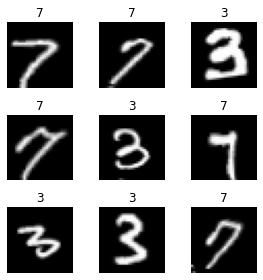

In [8]:
data.show_batch(rows = 3, figsize=(4, 4))

In [9]:
learn = cnn_learner(data, models.resnet18, metrics = accuracy)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


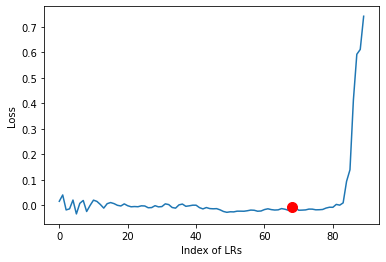

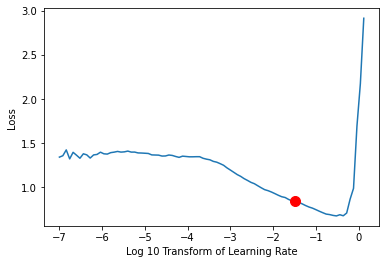

In [28]:
# Using the appropriate lr finder function by Andrew Chang from: https://forums.fast.ai/t/automated-learning-rate-suggester/44199
def find_appropriate_lr(model:Learner, lr_diff:int = 15, loss_threshold:float = .05, adjust_value:float = 1, plot:bool = False) -> float:
    #Run the Learning Rate Finder
    model.lr_find()
    
    #Get loss values and their corresponding gradients, and get lr values
    losses = np.array(model.recorder.losses)
    assert(lr_diff < len(losses))
    loss_grad = np.gradient(losses)
    lrs = model.recorder.lrs
    
    #Search for index in gradients where loss is lowest before the loss spike
    #Initialize right and left idx using the lr_diff as a spacing unit
    #Set the local min lr as -1 to signify if threshold is too low
    r_idx = -1
    l_idx = r_idx - lr_diff
    while (l_idx >= -len(losses)) and (abs(loss_grad[r_idx] - loss_grad[l_idx]) > loss_threshold):
        local_min_lr = lrs[l_idx]
        r_idx -= 1
        l_idx -= 1

    lr_to_use = local_min_lr * adjust_value
    
    if plot:
        # plots the gradients of the losses in respect to the learning rate change
        plt.plot(loss_grad)
        plt.plot(len(losses)+l_idx, loss_grad[l_idx],markersize=10,marker='o',color='red')
        plt.ylabel("Loss")
        plt.xlabel("Index of LRs")
        plt.show()

        plt.plot(np.log10(lrs), losses)
        plt.ylabel("Loss")
        plt.xlabel("Log 10 Transform of Learning Rate")
        loss_coord = np.interp(np.log10(lr_to_use), np.log10(lrs), losses)
        plt.plot(np.log10(lr_to_use), loss_coord, markersize=10,marker='o',color='red')
        plt.show()
        
    return lr_to_use

app_lr = find_appropriate_lr(learn, plot = True)

In [29]:
app_lr

0.03311311214825908

Min numerical gradient: 8.32E-04
Min loss divided by 10: 3.02E-02


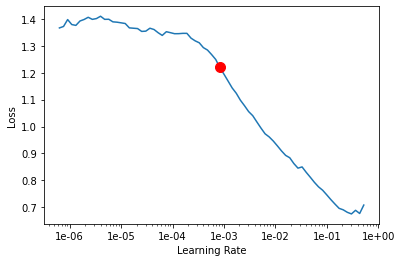

In [34]:
learn.recorder.plot(suggestion = True)

In [0]:
min_grad_lr = learn.recorder.min_grad_lr
min_loss = 3.02E-01
min_loss_by_10 = 3.02E-02

In [37]:
min_grad_lr = learn.recorder.min_grad_lr
lrs = [1E-7, 1E-6, 1E-5, 1E-4, min_grad_lr, 1E-3, 1E-2, min_loss_by_10, app_lr, 1E-1, min_loss, 1, 10, 100]
lrs

[1e-07,
 1e-06,
 1e-05,
 0.0001,
 0.0008317637711026709,
 0.001,
 0.01,
 0.0302,
 0.03311311214825908,
 0.1,
 0.302,
 1,
 10,
 100]

In [38]:
for lr in lrs:
  print("Starting to train model with lr = " + str(lr))
  learn = cnn_learner(data, models.resnet18, metrics = accuracy)
  learn.fit_one_cycle(4, lr)
  print("---------------------------------------------")

Starting to train model with lr = 1e-07


epoch,train_loss,valid_loss,accuracy,time
0,1.228271,0.757675,0.527897,00:10
1,1.268122,0.898120,0.470672,00:10
2,1.311266,0.966147,0.440629,00:10
3,1.328092,1.006780,0.436338,00:10


---------------------------------------------
Starting to train model with lr = 1e-06


epoch,train_loss,valid_loss,accuracy,time
0,1.341602,0.607522,0.666667,00:10
1,1.313967,0.701802,0.539342,00:10
2,1.296273,0.825829,0.460658,00:10
3,1.339327,0.883123,0.432046,00:10


---------------------------------------------
Starting to train model with lr = 1e-05


epoch,train_loss,valid_loss,accuracy,time
0,1.322010,0.733549,0.499285,00:11
1,1.374066,0.775356,0.466381,00:10
2,1.287256,0.808694,0.513591,00:10
3,1.286783,0.836999,0.510730,00:10


---------------------------------------------
Starting to train model with lr = 0.0001


epoch,train_loss,valid_loss,accuracy,time
0,1.255742,1.043303,0.223176,00:10
1,1.159775,0.863080,0.494993,00:10
2,1.080761,0.675873,0.626609,00:10
3,0.988677,0.621498,0.683834,00:10


---------------------------------------------
Starting to train model with lr = 0.0008317637711026709


epoch,train_loss,valid_loss,accuracy,time
0,1.150424,0.552347,0.695279,00:10
1,0.803547,0.487473,0.748212,00:10
2,0.645150,0.356302,0.851216,00:10
3,0.535697,0.304227,0.888412,00:10


---------------------------------------------
Starting to train model with lr = 0.001


epoch,train_loss,valid_loss,accuracy,time
0,1.144972,0.348245,0.834049,00:10
1,0.793328,0.300326,0.875537,00:11
2,0.651998,0.277506,0.902718,00:10
3,0.556866,0.262050,0.907010,00:10


---------------------------------------------
Starting to train model with lr = 0.01


epoch,train_loss,valid_loss,accuracy,time
0,0.735695,0.745267,0.775393,00:10
1,0.538543,0.095118,0.962804,00:10
2,0.375696,0.024031,0.988555,00:10
3,0.287507,0.023446,0.991416,00:10


---------------------------------------------
Starting to train model with lr = 0.0302


epoch,train_loss,valid_loss,accuracy,time
0,0.736973,0.452734,0.891273,00:10
1,0.486131,0.459232,0.912732,00:10
2,0.397567,0.043588,0.984263,00:10
3,0.356159,0.071230,0.985694,00:10


---------------------------------------------
Starting to train model with lr = 0.03311311214825908


epoch,train_loss,valid_loss,accuracy,time
0,0.793650,0.048535,0.987124,00:10
1,0.491833,0.021075,0.994278,00:10
2,0.341210,0.007670,0.998569,00:10
3,0.259666,0.022509,0.995708,00:10


---------------------------------------------
Starting to train model with lr = 0.1


epoch,train_loss,valid_loss,accuracy,time
0,0.673641,1.872666,0.841202,00:11
1,0.824446,0.976606,0.778255,00:10
2,0.605051,0.048187,0.991416,00:10
3,0.496009,0.044702,0.995708,00:10


---------------------------------------------
Starting to train model with lr = 0.302


epoch,train_loss,valid_loss,accuracy,time
0,1.573597,29.047604,0.492132,00:10
1,1.870075,8.560741,0.635193,00:10
2,1.955903,1.831795,0.859800,00:10
3,1.642938,0.107061,0.994278,00:10


---------------------------------------------
Starting to train model with lr = 1


epoch,train_loss,valid_loss,accuracy,time
0,6.514028,9254.939453,0.505007,00:10
1,26.486414,54478.132812,0.505007,00:10
2,23.494787,508.692200,0.587983,00:10
3,18.594702,1.417889,0.985694,00:10


---------------------------------------------
Starting to train model with lr = 10


epoch,train_loss,valid_loss,accuracy,time
0,564.911438,17936254976.000000,0.494993,00:14
1,1861.526733,34341232.000000,0.494993,00:11
2,1493.586426,56046.339844,0.573677,00:10
3,1100.506836,9.108387,0.992847,00:10


---------------------------------------------
Starting to train model with lr = 100


epoch,train_loss,valid_loss,accuracy,time
0,59707.132812,1495989504.000000,0.505007,00:10
1,41228.683594,15235.338867,0.505007,00:11
2,24961.294922,589.207092,0.505007,00:10
3,16539.419922,51.779709,0.505007,00:10


---------------------------------------------
